In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
main_path = r"E:\desktop\kansal sir\chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [5]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [6]:
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
5227  Pneumonia   
5228  Pneumonia   
5229  Pneumonia   
5230  Pneumonia   
5231  Pneumonia   

                                                                         image  
0       E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-1003233-0001.jpeg  
1       E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-1012843-0001.jpeg  
2       E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-1014768-0001.jpeg  
3       E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-1023731-0001.jpeg  
4       E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-1029510-0001.jpeg  
...                                                                        ...  
5227  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-9934736-0003.jpeg  
5228  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-9947411-0002.jpeg  
5229  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-9962961-0002.jpeg  
5230  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-9963654-0001.jpeg  
5231  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-9975428-0002.jpeg  

[5232 rows x 2 columns]

In [7]:
df_test

class  \
0       Normal   
1       Normal   
2       Normal   
3       Normal   
4       Normal   
..         ...   
619  Pneumonia   
620  Pneumonia   
621  Pneumonia   
622  Pneumonia   
623  Pneumonia   

                                                                       image  
0      E:\desktop\kansal sir\chest_xray\test/NORMAL\NORMAL-1049278-0001.jpeg  
1      E:\desktop\kansal sir\chest_xray\test/NORMAL\NORMAL-1110860-0001.jpeg  
2        E:\desktop\kansal sir\chest_xray\test/NORMAL\NORMAL-11419-0001.jpeg  
3       E:\desktop\kansal sir\chest_xray\test/NORMAL\NORMAL-115218-0001.jpeg  
4      E:\desktop\kansal sir\chest_xray\test/NORMAL\NORMAL-1160949-0001.jpeg  
..                                                                       ...  
619  E:\desktop\kansal sir\chest_xray\test/PNEUMONIA\VIRUS-9584831-0001.jpeg  
620  E:\desktop\kansal sir\chest_xray\test/PNEUMONIA\VIRUS-9671740-0001.jpeg  
621  E:\desktop\kansal sir\chest_xray\test/PNEUMONIA\VIRUS-9783315-0001.jpeg  
622  E:\desktop\kansal sir\chest_xray\test/PNEUMONIA\VIRUS-9890836-0001.jpeg  
623  E:\desktop\kansal sir\chest_xray\test/PNEUMONIA\VIRUS-9968655-0001.jpeg  

[624 rows x 2 columns]

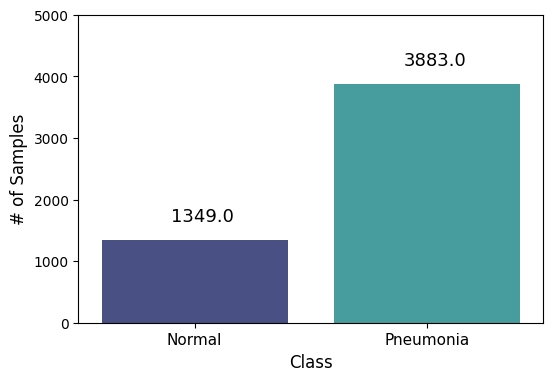

In [8]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

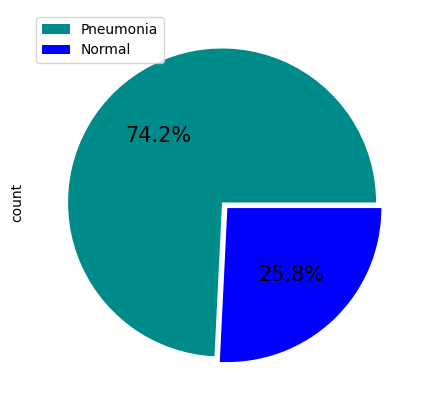

In [9]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

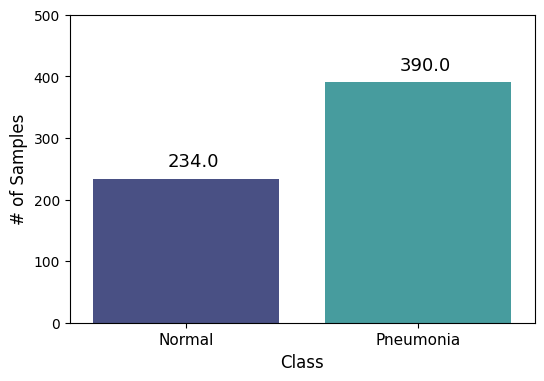

In [10]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

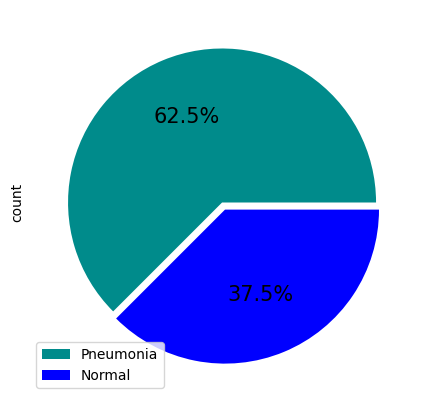

In [11]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

Train Set - Normal


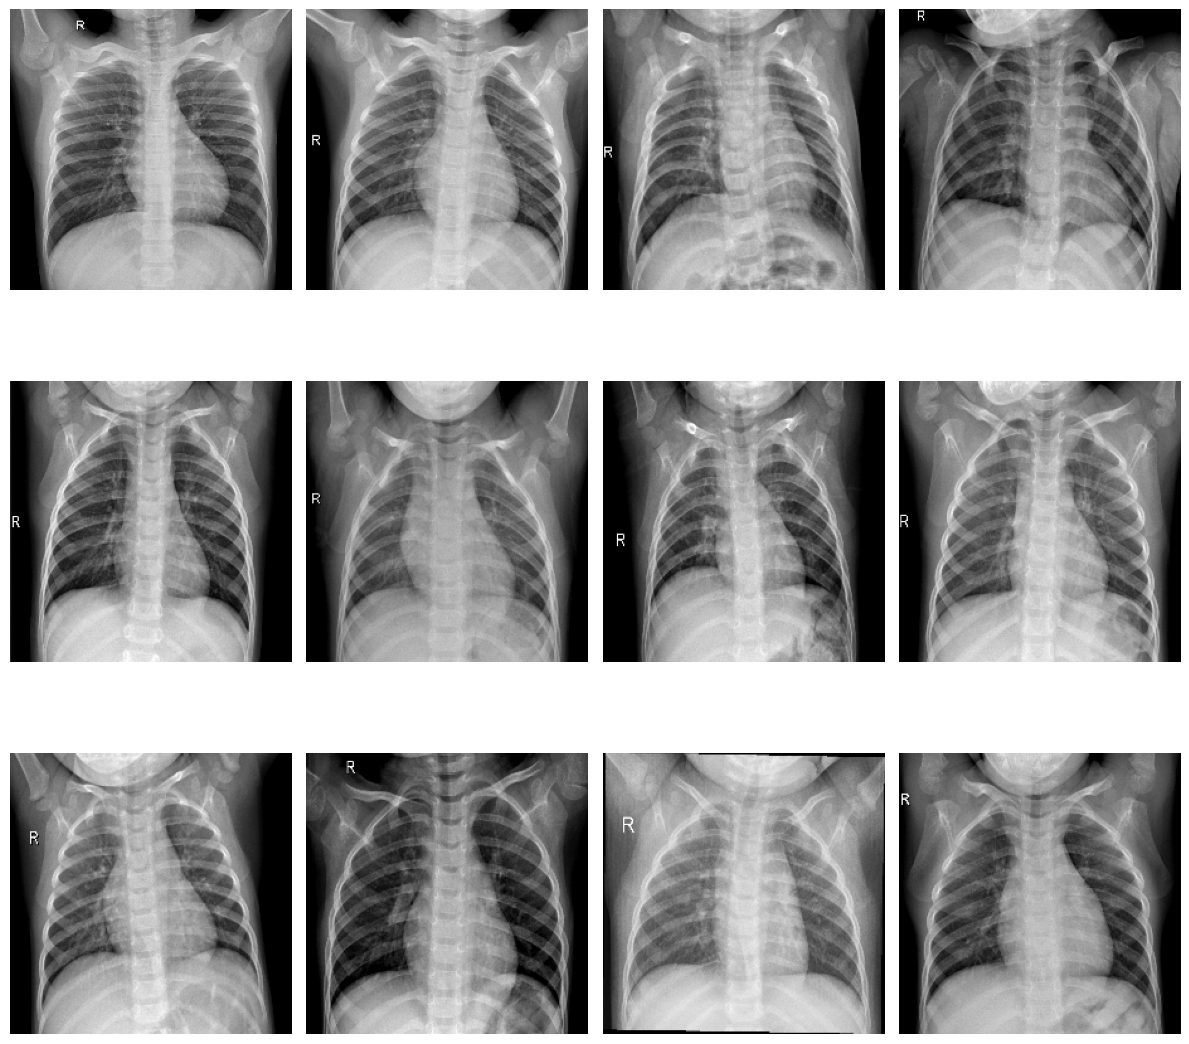

In [12]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


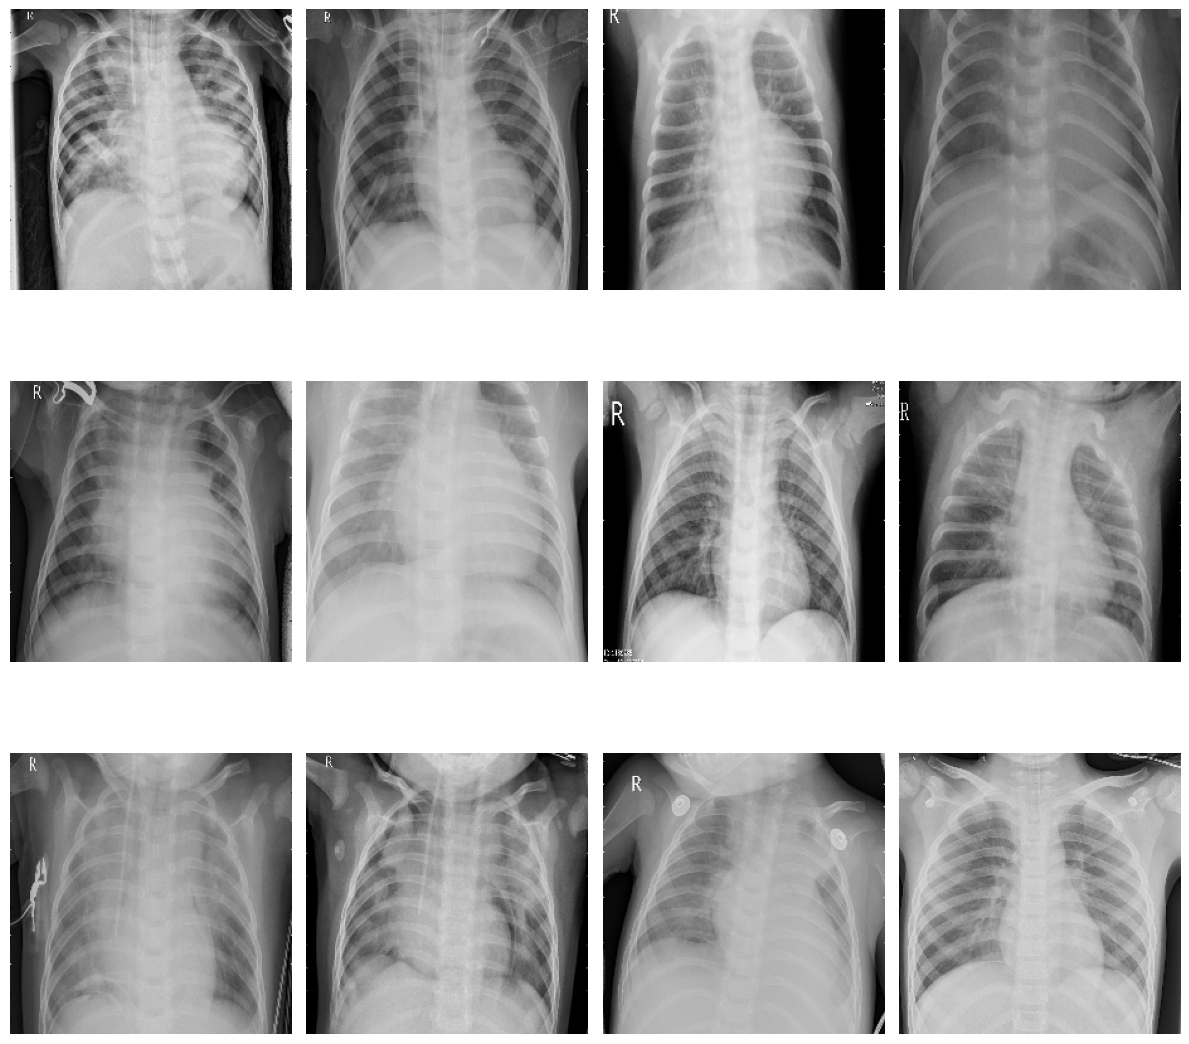

In [13]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


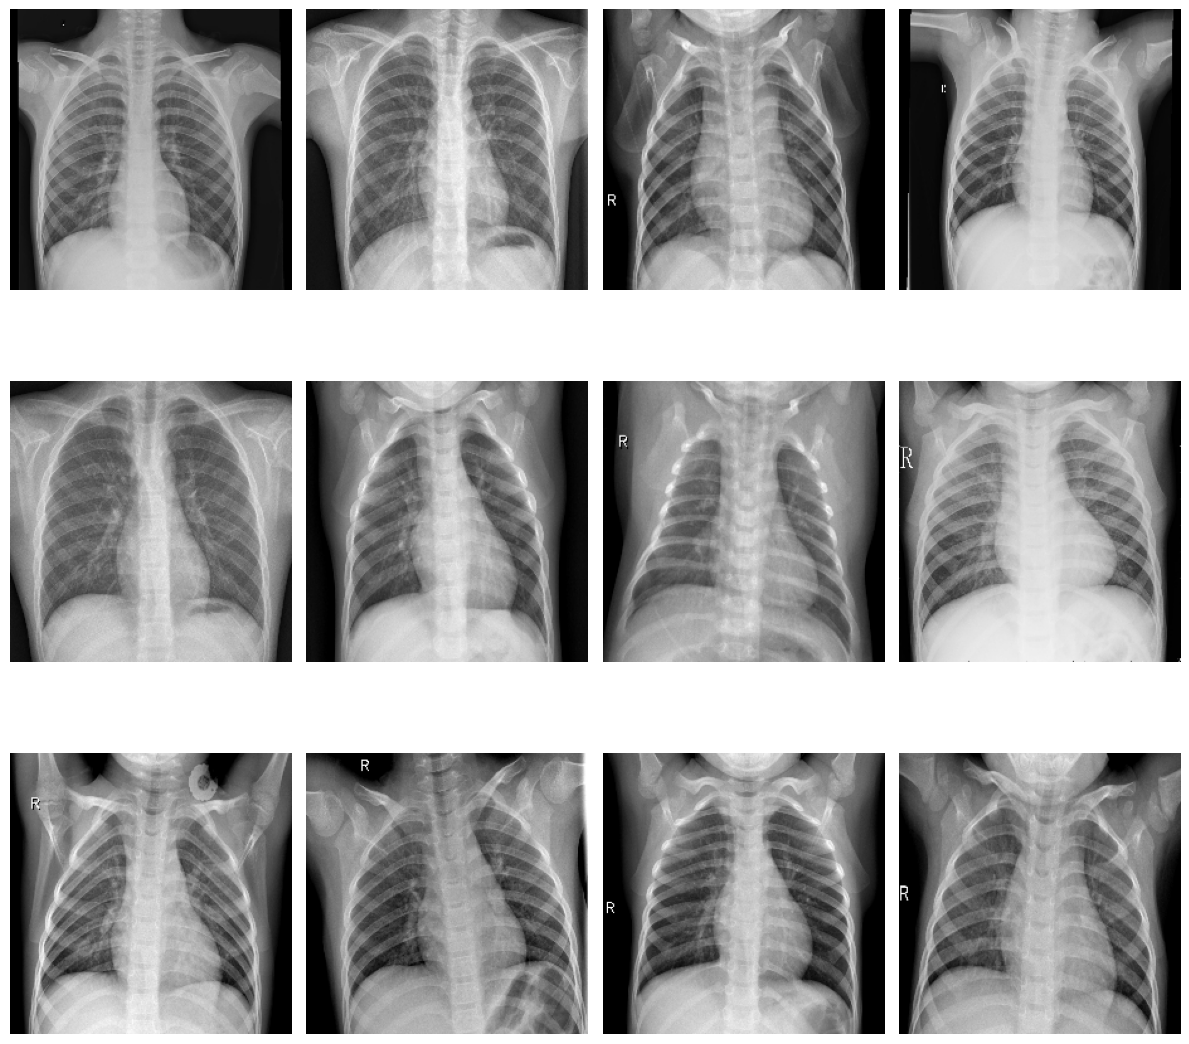

In [14]:

print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


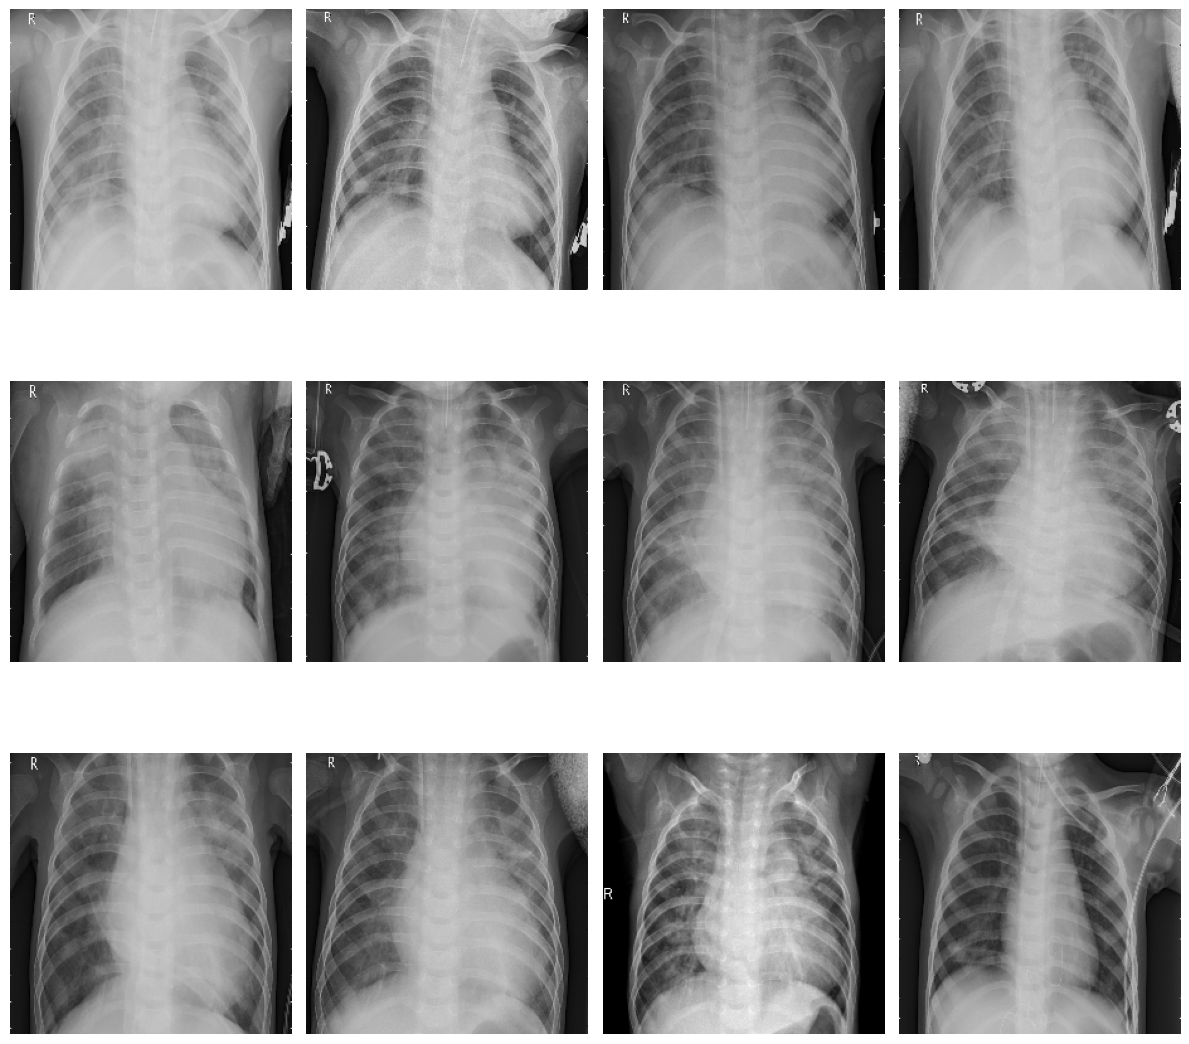

In [15]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [16]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [17]:
train_df

class  \
3566  Pneumonia   
2866  Pneumonia   
2681  Pneumonia   
1199     Normal   
4619  Pneumonia   
...         ...   
3476  Pneumonia   
678      Normal   
1560  Pneumonia   
2769  Pneumonia   
4881  Pneumonia   

                                                                            image  
3566  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-8718799-0001.jpeg  
2866  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-6295192-0003.jpeg  
2681  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-5615122-0001.jpeg  
1199       E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-9031828-0001.jpeg  
4619     E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-5822550-0001.jpeg  
...                                                                           ...  
3476  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-8467199-0001.jpeg  
678        E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-5634312-0001.jpeg  
1560  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-1797366-0001.jpeg  
2769  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-5965088-0001.jpeg  
4881     E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-7611162-0001.jpeg  

[4185 rows x 2 columns]

In [18]:
val_df

class  \
2945  Pneumonia   
4878  Pneumonia   
3177  Pneumonia   
972      Normal   
3059  Pneumonia   
...         ...   
253      Normal   
4315  Pneumonia   
687      Normal   
3417  Pneumonia   
3745  Pneumonia   

                                                                            image  
2945   E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-654117-0001.jpeg  
4878     E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-7603659-0001.jpeg  
3177  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-7512869-0002.jpeg  
972        E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-7436212-0002.jpeg  
3059  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-7022864-0004.jpeg  
...                                                                           ...  
253        E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-2699389-0002.jpeg  
4315     E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\VIRUS-3896078-0002.jpeg  
687         E:\desktop\kansal sir\chest_xray\train/NORMAL\NORMAL-566227-0001.jpeg  
3417  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-8313249-0001.jpeg  
3745  E:\desktop\kansal sir\chest_xray\train/PNEUMONIA\BACTERIA-9424776-0005.jpeg  

[1047 rows x 2 columns]

In [19]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [20]:

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [21]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [22]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics=['binary_accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

In [24]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 20,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=int(len(train_df)/BATCH),
          validation_steps=int(len(val_df)/BATCH));

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - binary_accuracy: 0.8902 - loss: 0.2671 - val_binary_accuracy: 0.7441 - val_loss: 1.8931 - learning_rate: 6.0000e-06
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - binary_accuracy: 0.8750 - loss: 0.2357
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.1999999514955563e-06.
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - binary_accuracy: 0.8750 - loss: 0.2357 - val_binary_accuracy: 0.7432 - val_loss: 1.8938 - learning_rate: 6.0000e-06
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - binary_accuracy: 0.8878 - loss: 0.2588 - val_binary_accuracy: 0.7451 - val_loss: 1.0327 - learning_rate: 1.2000e-06
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - binary_accuracy: 0.9062 - loss: 0.1801 - val_binary_accuracy: 0.7422 - val_loss: 1.0391 - learning_rate: 1.2000e-06
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - binary_accuracy: 0.9003 - loss: 0.2407 - val_binary_accuracy: 0.8516 - val_loss: 0.2912 - learnin

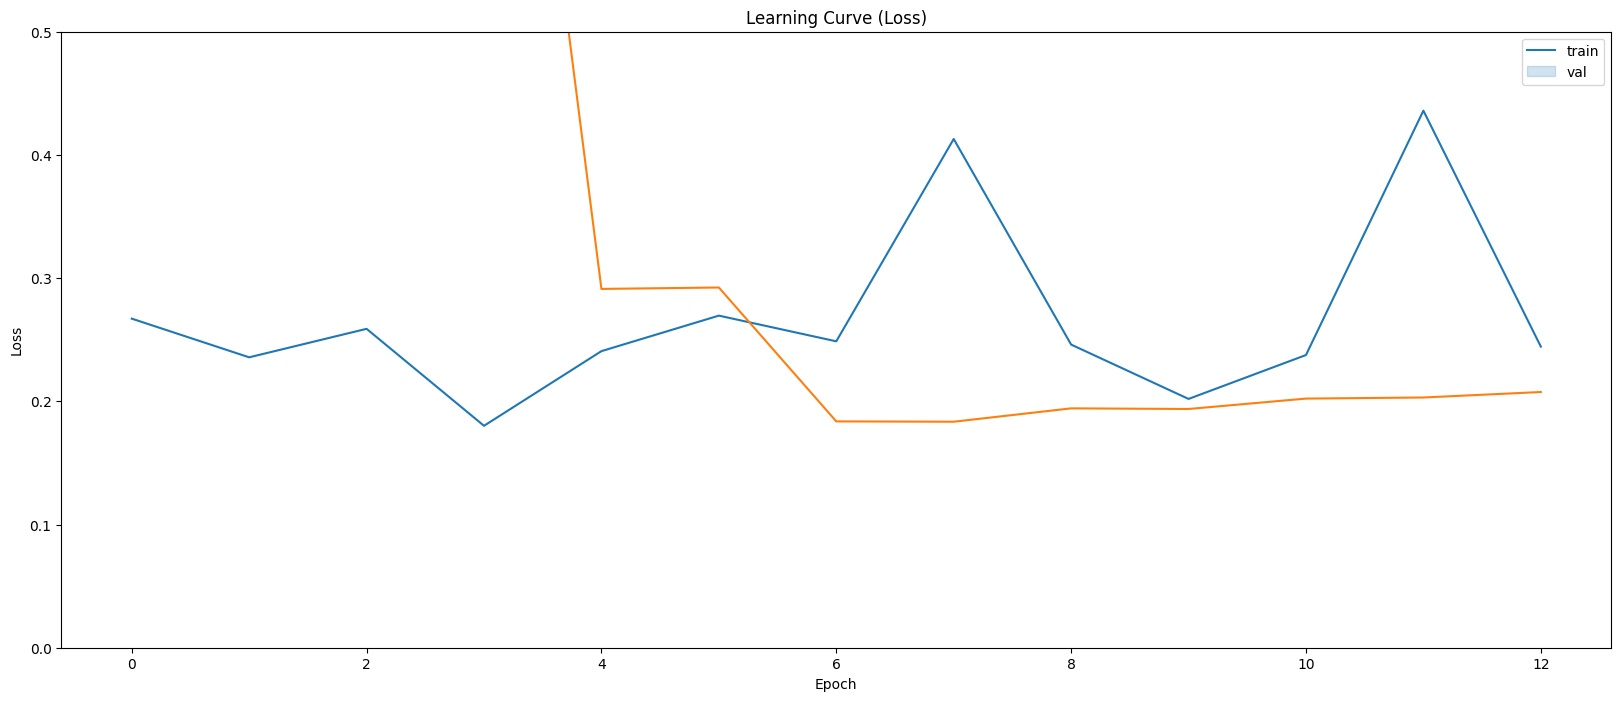

In [25]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

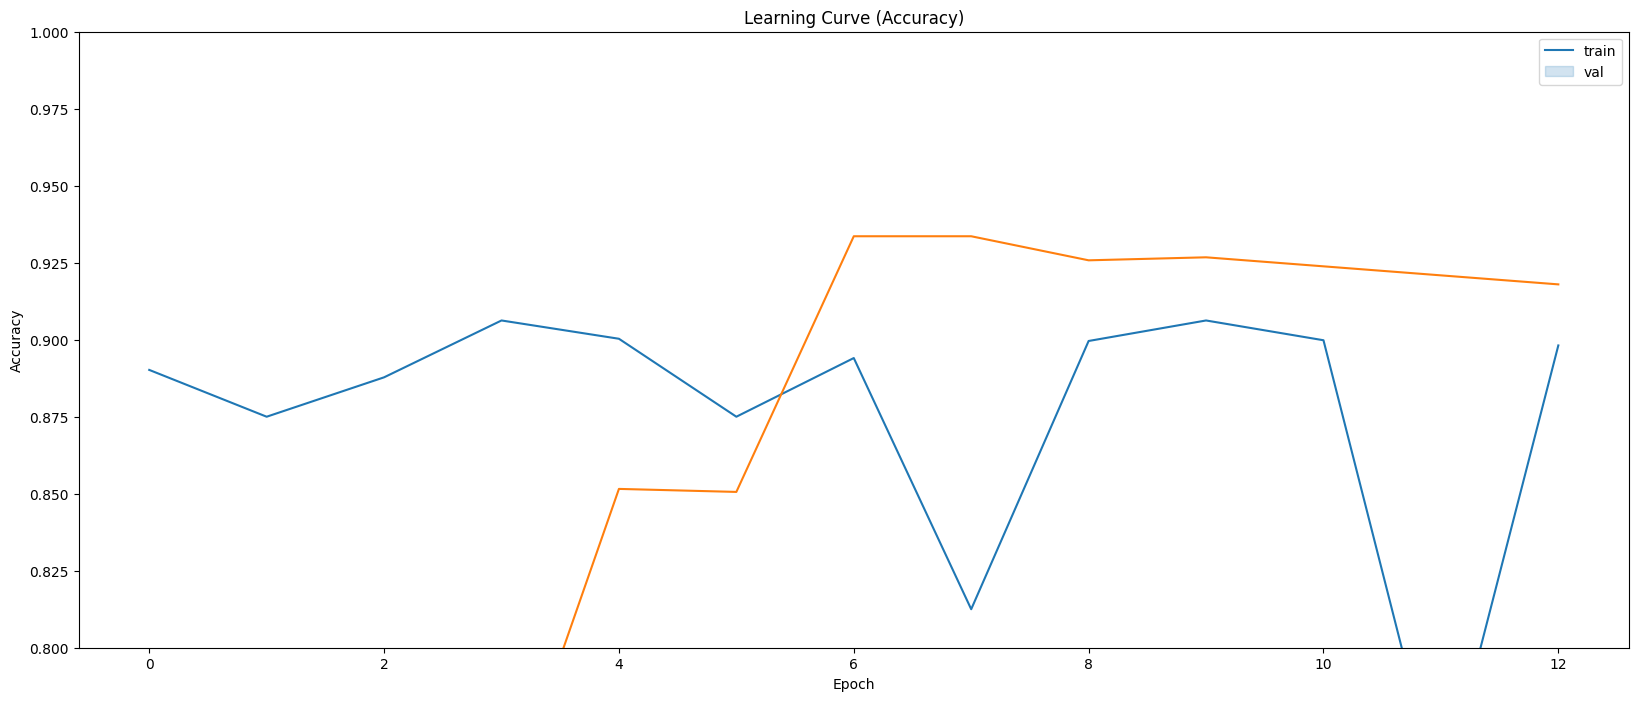

In [26]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [27]:
score = model.evaluate(ds_val, steps = int(len(val_df)/BATCH), verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1809273213148117
Val accuracy: 0.935546875


In [28]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3517930507659912
Test accuracy: 0.8605769276618958


In [30]:
score = model.evaluate(ds_train, steps = len(df_train), verbose = 0)

print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.435898095369339
Train accuracy: 0.800000011920929


In [31]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


In [32]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [34]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 20,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=int(len(train_df)/BATCH),
          validation_steps=int(len(val_df)/BATCH));

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1536s 12s/step - binary_accuracy: 0.8180 - loss: 0.3975 - val_binary_accuracy: 0.9248 - val_loss: 0.2283 - learning_rate: 5.0000e-05
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 14:31 7s/step - binary_accuracy: 0.9062 - loss: 0.2850
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
130/130 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - binary_accuracy: 0.9062 - loss: 0.2850 - val_binary_accuracy: 0.9277 - val_loss: 0.2255 - learning_rate: 5.0000e-05
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1068s 8s/step - binary_accuracy: 0.9237 - loss: 0.2159 - val_binary_accuracy: 0.9316 - val_loss: 0.2048 - learning_rate: 1.0000e-05
Epoch 4/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 14:25 7s/step - binary_accuracy: 0.9062 - loss: 0.2943
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
130/130 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - binary_accuracy: 0.9062 - loss: 0.2943 - val_binary_accuracy: 0.9297 - val_loss: 0.2097 - learning_rate: 1.0

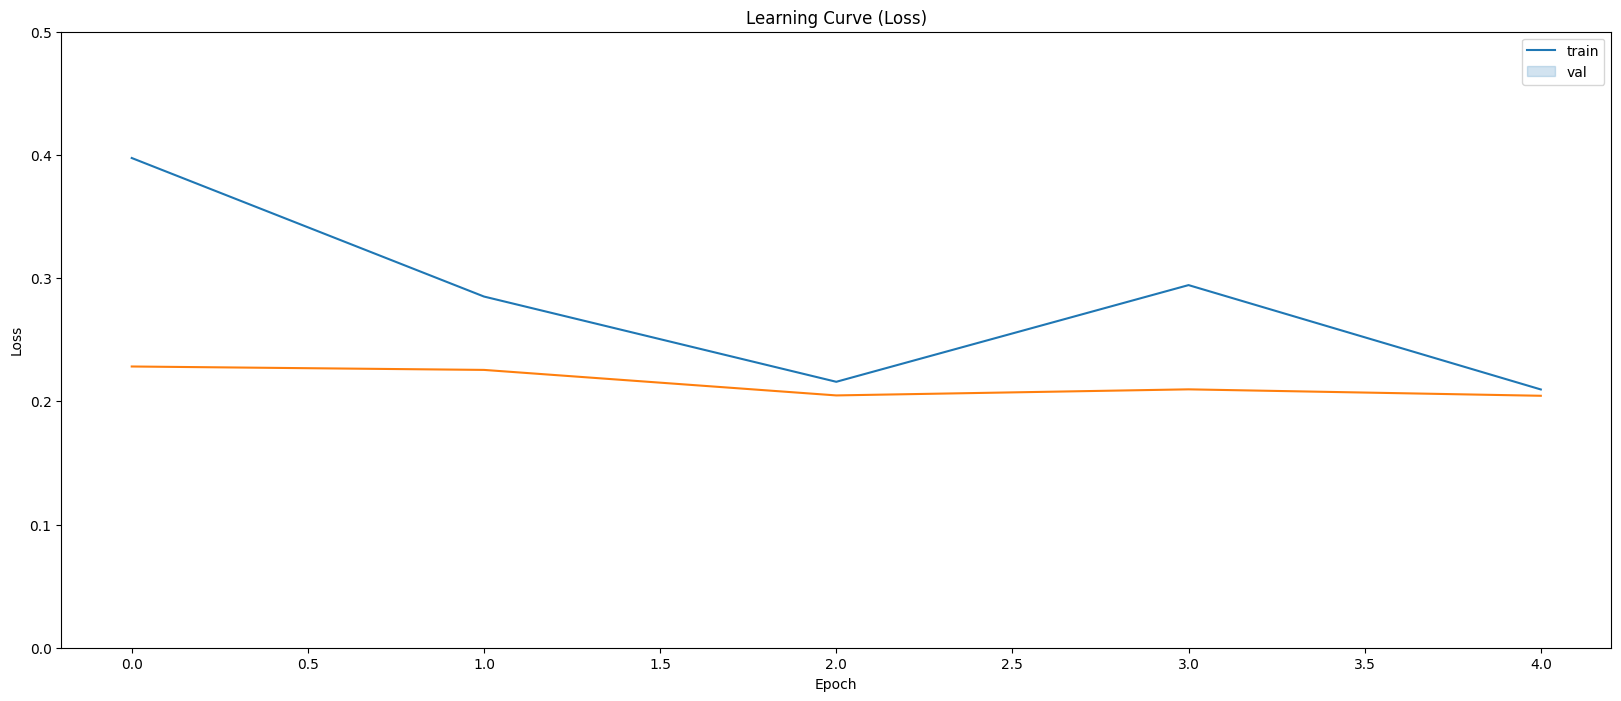

In [35]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

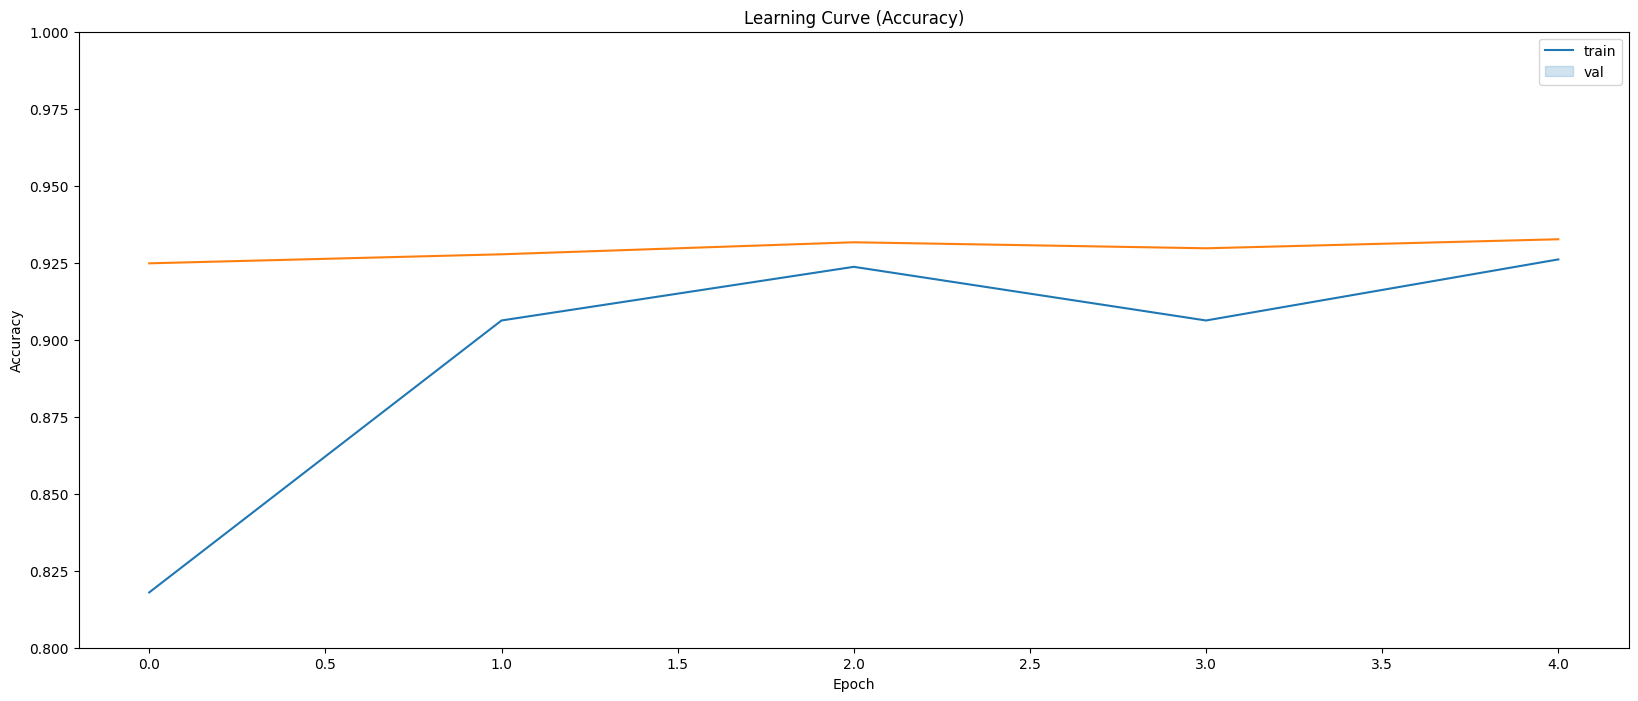

In [36]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [38]:
score = model_pretrained.evaluate(ds_val, steps = int(len(val_df)/BATCH), verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.22600652277469635
Val accuracy: 0.9267578125


In [39]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.37573105096817017
Test accuracy: 0.8301281929016113


In [42]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [43]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 4,731,137 (18.05 MB)

 Non-trainable params: 53,862,912 (205.47 MB)

In [44]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 6,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=int(len(train_df)/BATCH),
          validation_steps=int(len(val_df)/BATCH));

Epoch 1/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 1203s 9s/step - binary_accuracy: 0.8745 - loss: 0.3552 - val_binary_accuracy: 0.9170 - val_loss: 0.2852 - learning_rate: 2.0000e-06
Epoch 2/6
  1/130 ━━━━━━━━━━━━━━━━━━━━ 16:48 8s/step - binary_accuracy: 0.8750 - loss: 0.3150
Epoch 2: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
130/130 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - binary_accuracy: 0.8750 - loss: 0.3150 - val_binary_accuracy: 0.9170 - val_loss: 0.2860 - learning_rate: 2.0000e-06
Epoch 3/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 1035s 8s/step - binary_accuracy: 0.9015 - loss: 0.3142 - val_binary_accuracy: 0.9189 - val_loss: 0.2918 - learning_rate: 4.0000e-07
Epoch 4/6
  1/130 ━━━━━━━━━━━━━━━━━━━━ 13:46 6s/step - binary_accuracy: 0.9688 - loss: 0.2127
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.00000009348878e-08.
130/130 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - binary_accuracy: 0.9688 - loss: 0.2127 - val_binary_accuracy: 0.9170 - val_loss: 0.2939 - learning_rate: 4.0000e-07

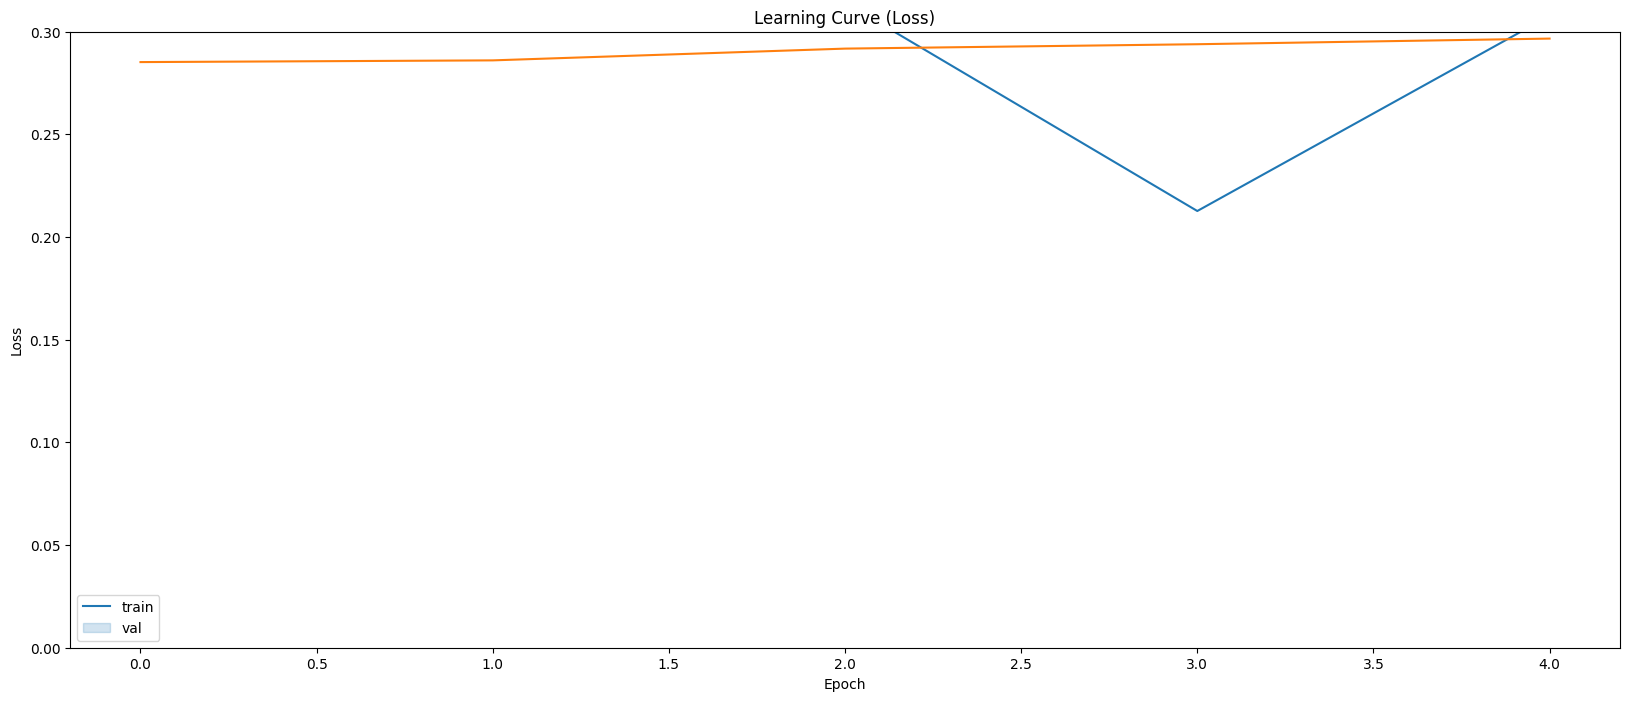

In [45]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

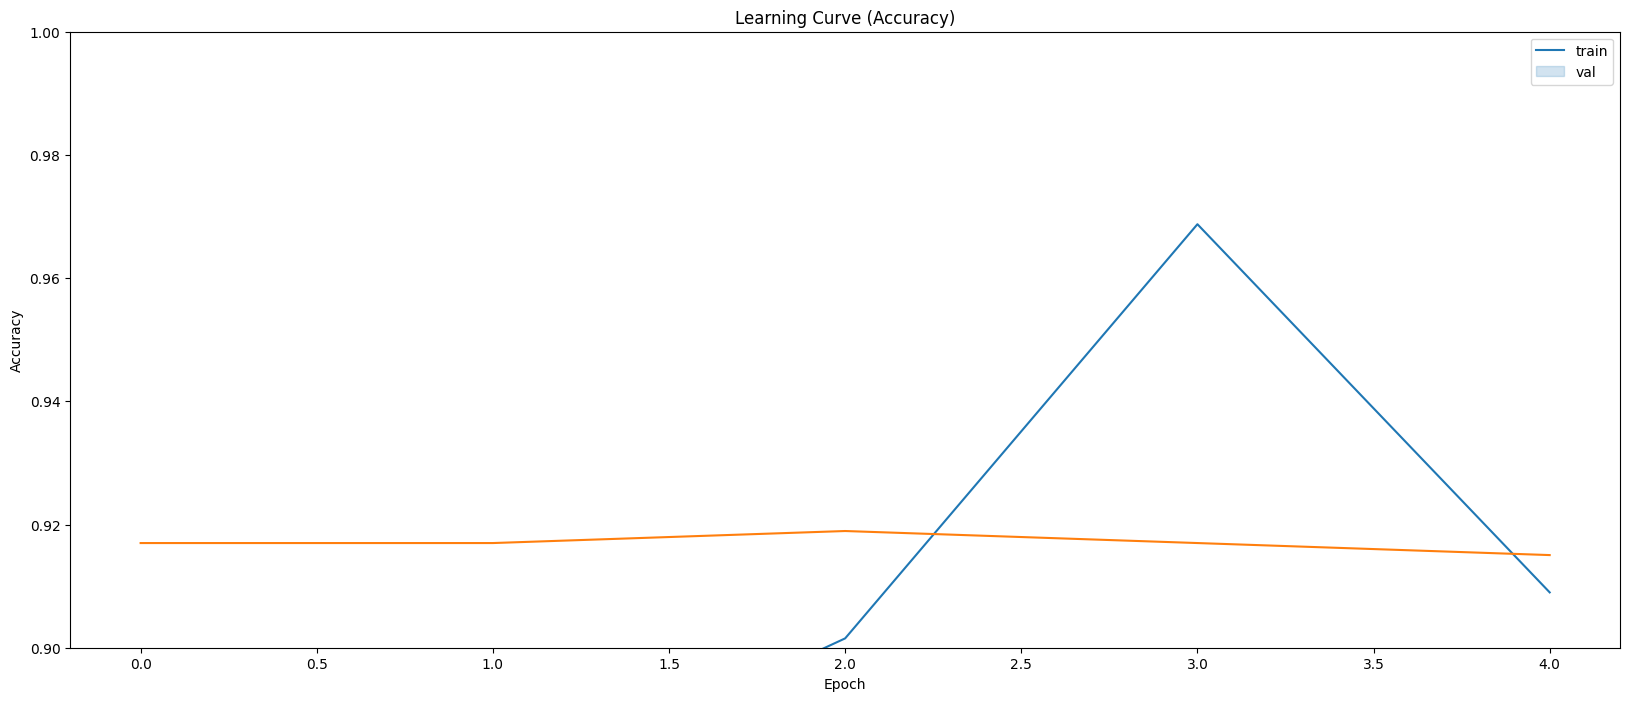

In [46]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [47]:
score = model_pretrained.evaluate(ds_val, steps = int(len(val_df)/BATCH), verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.28374242782592773
Val accuracy: 0.9189453125


In [48]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4206359088420868
Test accuracy: 0.8060897588729858


In [49]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [50]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [51]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8060897435897436


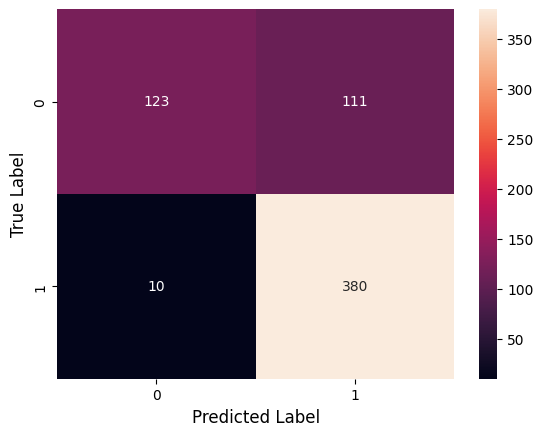

In [52]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [53]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.92      0.53      0.67       234
           1       0.77      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624



ROC_AUC:  0.9151654613193075


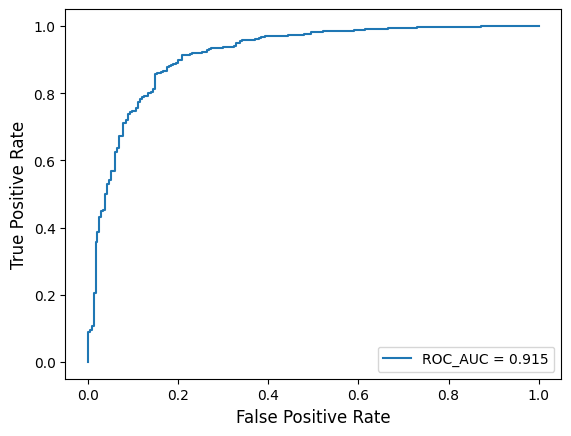

In [54]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [55]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,862,821 (29.99 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 5,241,732 (20.00 MB)

In [59]:
 for i,layer in enumerate(model.layers):
     print(i, layer.name, getattr(layer, 'output_shape', None))

0 input_layer None
1 conv2d None
2 batch_normalization None
3 activation None
4 max_pooling2d None
5 dropout None
6 conv2d_1 None
7 batch_normalization_1 None
8 activation_1 None
9 max_pooling2d_1 None
10 dropout_1 None
11 conv2d_2 None
12 conv2d_3 None
13 batch_normalization_2 None
14 activation_2 None
15 max_pooling2d_2 None
16 dropout_2 None
17 flatten None
18 dense None
19 dropout_3 None
20 dense_1 None


In [63]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Path to your image file
img_path = r"E:\desktop\kansal sir\chest_xray\test\NORMAL\NORMAL-78265-0001.jpeg"

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))   # size depends on your model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)            # shape becomes (1, 224, 224, 3)
img_array = preprocess_input(img_array)


In [65]:
[layer.name for layer in model.layers if "conv" in layer.name]


['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3']


# Grad-CAM utilities added automatically

I've added Grad-CAM helper functions and example usage cells for both **TensorFlow / Keras** and **PyTorch**.
- If your notebook uses **Keras/TensorFlow**, run the Keras cell (it requires you to provide the `model`, the `image`, and the `last_conv_layer_name`).
- If your notebook uses **PyTorch**, run the PyTorch cell (it requires the `model`, the `image_tensor`, and the `target_layer`).

**Notes**
- These helper functions assume you have a trained model already loaded in the notebook namespace (variable names described in the usage cells).
- If the notebook uses a different model variable name, either rename it or set the appropriate variable before running the example usage cell.
- After running the Grad-CAM cell, a heatmap overlay image will be displayed inline.


In [ ]:

# === Grad-CAM for TensorFlow / Keras ===
# Usage:
# 1. Ensure `model` is the tf.keras.Model you trained/loaded.
# 2. Provide a preprocessed image array `img_array` with shape (1, H, W, C) (batch dimension included),
#    and the pixel scaling that your model expects.
# 3. Set `last_conv_layer_name` to the name of the last convolutional layer in your model.
# 4. Optionally set `pred_index` to the class index you want explanation for (default: model's top prediction).


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

def make_gradcam_heatmap(img_array, model, conv2d_3, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the model's predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("conv2d_3").output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is"
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 & 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()
    return heatmap

def overlay_heatmap(img_array, heatmap, alpha=0.4, cmap='jet'):
    # img_array expected shape: (1, H, W, C) or (H, W, C)
    if img_array.ndim==4:
        img = img_array[0]
    else:
        img = img_array
    # Ensure image is in 0-255 range for overlay
    img_uint8 = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-8))
    heatmap_resized = np.uint8(255 * heatmap)
    import cv2
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255.0
    img_float = np.float32(img_uint8) / 255.0
    overlay = heatmap_colored * alpha + img_float
    overlay = overlay / np.max(overlay)
    return overlay

def compute_and_display_gradcam_keras(model, img_array, conv2d_3, pred_index=None, alpha=0.4):
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_3", pred_index)
    overlay = overlay_heatmap(img_array, heatmap, alpha=alpha)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Grad-CAM overlay (Keras)')
    plt.show()



In [ ]:
# === IMPORTS ===
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input  # specific to ResNetV2

# === 1️⃣ MAKE GRAD-CAM HEATMAP ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Access nested base model (ResNet152V2 inside your model_pretrained)
    base_model = model.get_layer("resnet152v2")

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [base_model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


# === 2️⃣ OVERLAY HEATMAP ===
def overlay_heatmap(img_array, heatmap, alpha=0.4):
    if img_array.ndim == 4:
        img = img_array[0]
    else:
        img = img_array

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    overlay = np.float32(img) / 255 + np.float32(heatmap_colored) / 255 * alpha
    overlay = overlay / np.max(overlay)
    return overlay

# === 3️⃣ DISPLAY GRAD-CAM ===
def compute_and_display_gradcam_keras(model, img_array, last_conv_layer_name, pred_index=None, alpha=0.4):
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)
    overlay = overlay_heatmap(img_array, heatmap, alpha)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Grad-CAM Heatmap (ResNet152V2)')
    plt.show()


# === 4️⃣ LOAD & PREPROCESS IMAGE ===
img_path = r"E:\desktop\kansal sir\chest_xray\test\NORMAL\NORMAL-78265-0001.jpeg"  # <-- change path

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # for ResNetV2 models


# === 5️⃣ RUN GRAD-CAM ===
last_conv_layer_name = "conv2d_3"   # for ResNet152V2

# To verify the layer name if error occurs:
# print([layer.name for layer in model_pretrained.layers if "conv" in layer.name][-10:])

compute_and_display_gradcam_keras(model_pretrained, img_array, last_conv_layer_name)


ValueError: No such layer: conv2d_3. Existing layers are: ['input_layer_1', 'conv1_pad', 'conv1_conv', 'pool1_pad', 'pool1_pool', 'conv2_block1_preact_bn', 'conv2_block1_preact_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_pad', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_out', 'conv2_block2_preact_bn', 'conv2_block2_preact_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_pad', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_out', 'conv2_block3_preact_bn', 'conv2_block3_preact_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_pad', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'max_pooling2d_3', 'conv2_block3_3_conv', 'conv2_block3_out', 'conv3_block1_preact_bn', 'conv3_block1_preact_relu', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_pad', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_out', 'conv3_block2_preact_bn', 'conv3_block2_preact_relu', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_pad', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_out', 'conv3_block3_preact_bn', 'conv3_block3_preact_relu', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_pad', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_out', 'conv3_block4_preact_bn', 'conv3_block4_preact_relu', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_pad', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'conv3_block4_3_conv', 'conv3_block4_out', 'conv3_block5_preact_bn', 'conv3_block5_preact_relu', 'conv3_block5_1_conv', 'conv3_block5_1_bn', 'conv3_block5_1_relu', 'conv3_block5_2_pad', 'conv3_block5_2_conv', 'conv3_block5_2_bn', 'conv3_block5_2_relu', 'conv3_block5_3_conv', 'conv3_block5_out', 'conv3_block6_preact_bn', 'conv3_block6_preact_relu', 'conv3_block6_1_conv', 'conv3_block6_1_bn', 'conv3_block6_1_relu', 'conv3_block6_2_pad', 'conv3_block6_2_conv', 'conv3_block6_2_bn', 'conv3_block6_2_relu', 'conv3_block6_3_conv', 'conv3_block6_out', 'conv3_block7_preact_bn', 'conv3_block7_preact_relu', 'conv3_block7_1_conv', 'conv3_block7_1_bn', 'conv3_block7_1_relu', 'conv3_block7_2_pad', 'conv3_block7_2_conv', 'conv3_block7_2_bn', 'conv3_block7_2_relu', 'conv3_block7_3_conv', 'conv3_block7_out', 'conv3_block8_preact_bn', 'conv3_block8_preact_relu', 'conv3_block8_1_conv', 'conv3_block8_1_bn', 'conv3_block8_1_relu', 'conv3_block8_2_pad', 'conv3_block8_2_conv', 'conv3_block8_2_bn', 'conv3_block8_2_relu', 'max_pooling2d_4', 'conv3_block8_3_conv', 'conv3_block8_out', 'conv4_block1_preact_bn', 'conv4_block1_preact_relu', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_pad', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_out', 'conv4_block2_preact_bn', 'conv4_block2_preact_relu', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_pad', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_out', 'conv4_block3_preact_bn', 'conv4_block3_preact_relu', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_pad', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_out', 'conv4_block4_preact_bn', 'conv4_block4_preact_relu', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_pad', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_out', 'conv4_block5_preact_bn', 'conv4_block5_preact_relu', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_pad', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_out', 'conv4_block6_preact_bn', 'conv4_block6_preact_relu', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_pad', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_out', 'conv4_block7_preact_bn', 'conv4_block7_preact_relu', 'conv4_block7_1_conv', 'conv4_block7_1_bn', 'conv4_block7_1_relu', 'conv4_block7_2_pad', 'conv4_block7_2_conv', 'conv4_block7_2_bn', 'conv4_block7_2_relu', 'conv4_block7_3_conv', 'conv4_block7_out', 'conv4_block8_preact_bn', 'conv4_block8_preact_relu', 'conv4_block8_1_conv', 'conv4_block8_1_bn', 'conv4_block8_1_relu', 'conv4_block8_2_pad', 'conv4_block8_2_conv', 'conv4_block8_2_bn', 'conv4_block8_2_relu', 'conv4_block8_3_conv', 'conv4_block8_out', 'conv4_block9_preact_bn', 'conv4_block9_preact_relu', 'conv4_block9_1_conv', 'conv4_block9_1_bn', 'conv4_block9_1_relu', 'conv4_block9_2_pad', 'conv4_block9_2_conv', 'conv4_block9_2_bn', 'conv4_block9_2_relu', 'conv4_block9_3_conv', 'conv4_block9_out', 'conv4_block10_preact_bn', 'conv4_block10_preact_relu', 'conv4_block10_1_conv', 'conv4_block10_1_bn', 'conv4_block10_1_relu', 'conv4_block10_2_pad', 'conv4_block10_2_conv', 'conv4_block10_2_bn', 'conv4_block10_2_relu', 'conv4_block10_3_conv', 'conv4_block10_out', 'conv4_block11_preact_bn', 'conv4_block11_preact_relu', 'conv4_block11_1_conv', 'conv4_block11_1_bn', 'conv4_block11_1_relu', 'conv4_block11_2_pad', 'conv4_block11_2_conv', 'conv4_block11_2_bn', 'conv4_block11_2_relu', 'conv4_block11_3_conv', 'conv4_block11_out', 'conv4_block12_preact_bn', 'conv4_block12_preact_relu', 'conv4_block12_1_conv', 'conv4_block12_1_bn', 'conv4_block12_1_relu', 'conv4_block12_2_pad', 'conv4_block12_2_conv', 'conv4_block12_2_bn', 'conv4_block12_2_relu', 'conv4_block12_3_conv', 'conv4_block12_out', 'conv4_block13_preact_bn', 'conv4_block13_preact_relu', 'conv4_block13_1_conv', 'conv4_block13_1_bn', 'conv4_block13_1_relu', 'conv4_block13_2_pad', 'conv4_block13_2_conv', 'conv4_block13_2_bn', 'conv4_block13_2_relu', 'conv4_block13_3_conv', 'conv4_block13_out', 'conv4_block14_preact_bn', 'conv4_block14_preact_relu', 'conv4_block14_1_conv', 'conv4_block14_1_bn', 'conv4_block14_1_relu', 'conv4_block14_2_pad', 'conv4_block14_2_conv', 'conv4_block14_2_bn', 'conv4_block14_2_relu', 'conv4_block14_3_conv', 'conv4_block14_out', 'conv4_block15_preact_bn', 'conv4_block15_preact_relu', 'conv4_block15_1_conv', 'conv4_block15_1_bn', 'conv4_block15_1_relu', 'conv4_block15_2_pad', 'conv4_block15_2_conv', 'conv4_block15_2_bn', 'conv4_block15_2_relu', 'conv4_block15_3_conv', 'conv4_block15_out', 'conv4_block16_preact_bn', 'conv4_block16_preact_relu', 'conv4_block16_1_conv', 'conv4_block16_1_bn', 'conv4_block16_1_relu', 'conv4_block16_2_pad', 'conv4_block16_2_conv', 'conv4_block16_2_bn', 'conv4_block16_2_relu', 'conv4_block16_3_conv', 'conv4_block16_out', 'conv4_block17_preact_bn', 'conv4_block17_preact_relu', 'conv4_block17_1_conv', 'conv4_block17_1_bn', 'conv4_block17_1_relu', 'conv4_block17_2_pad', 'conv4_block17_2_conv', 'conv4_block17_2_bn', 'conv4_block17_2_relu', 'conv4_block17_3_conv', 'conv4_block17_out', 'conv4_block18_preact_bn', 'conv4_block18_preact_relu', 'conv4_block18_1_conv', 'conv4_block18_1_bn', 'conv4_block18_1_relu', 'conv4_block18_2_pad', 'conv4_block18_2_conv', 'conv4_block18_2_bn', 'conv4_block18_2_relu', 'conv4_block18_3_conv', 'conv4_block18_out', 'conv4_block19_preact_bn', 'conv4_block19_preact_relu', 'conv4_block19_1_conv', 'conv4_block19_1_bn', 'conv4_block19_1_relu', 'conv4_block19_2_pad', 'conv4_block19_2_conv', 'conv4_block19_2_bn', 'conv4_block19_2_relu', 'conv4_block19_3_conv', 'conv4_block19_out', 'conv4_block20_preact_bn', 'conv4_block20_preact_relu', 'conv4_block20_1_conv', 'conv4_block20_1_bn', 'conv4_block20_1_relu', 'conv4_block20_2_pad', 'conv4_block20_2_conv', 'conv4_block20_2_bn', 'conv4_block20_2_relu', 'conv4_block20_3_conv', 'conv4_block20_out', 'conv4_block21_preact_bn', 'conv4_block21_preact_relu', 'conv4_block21_1_conv', 'conv4_block21_1_bn', 'conv4_block21_1_relu', 'conv4_block21_2_pad', 'conv4_block21_2_conv', 'conv4_block21_2_bn', 'conv4_block21_2_relu', 'conv4_block21_3_conv', 'conv4_block21_out', 'conv4_block22_preact_bn', 'conv4_block22_preact_relu', 'conv4_block22_1_conv', 'conv4_block22_1_bn', 'conv4_block22_1_relu', 'conv4_block22_2_pad', 'conv4_block22_2_conv', 'conv4_block22_2_bn', 'conv4_block22_2_relu', 'conv4_block22_3_conv', 'conv4_block22_out', 'conv4_block23_preact_bn', 'conv4_block23_preact_relu', 'conv4_block23_1_conv', 'conv4_block23_1_bn', 'conv4_block23_1_relu', 'conv4_block23_2_pad', 'conv4_block23_2_conv', 'conv4_block23_2_bn', 'conv4_block23_2_relu', 'conv4_block23_3_conv', 'conv4_block23_out', 'conv4_block24_preact_bn', 'conv4_block24_preact_relu', 'conv4_block24_1_conv', 'conv4_block24_1_bn', 'conv4_block24_1_relu', 'conv4_block24_2_pad', 'conv4_block24_2_conv', 'conv4_block24_2_bn', 'conv4_block24_2_relu', 'conv4_block24_3_conv', 'conv4_block24_out', 'conv4_block25_preact_bn', 'conv4_block25_preact_relu', 'conv4_block25_1_conv', 'conv4_block25_1_bn', 'conv4_block25_1_relu', 'conv4_block25_2_pad', 'conv4_block25_2_conv', 'conv4_block25_2_bn', 'conv4_block25_2_relu', 'conv4_block25_3_conv', 'conv4_block25_out', 'conv4_block26_preact_bn', 'conv4_block26_preact_relu', 'conv4_block26_1_conv', 'conv4_block26_1_bn', 'conv4_block26_1_relu', 'conv4_block26_2_pad', 'conv4_block26_2_conv', 'conv4_block26_2_bn', 'conv4_block26_2_relu', 'conv4_block26_3_conv', 'conv4_block26_out', 'conv4_block27_preact_bn', 'conv4_block27_preact_relu', 'conv4_block27_1_conv', 'conv4_block27_1_bn', 'conv4_block27_1_relu', 'conv4_block27_2_pad', 'conv4_block27_2_conv', 'conv4_block27_2_bn', 'conv4_block27_2_relu', 'conv4_block27_3_conv', 'conv4_block27_out', 'conv4_block28_preact_bn', 'conv4_block28_preact_relu', 'conv4_block28_1_conv', 'conv4_block28_1_bn', 'conv4_block28_1_relu', 'conv4_block28_2_pad', 'conv4_block28_2_conv', 'conv4_block28_2_bn', 'conv4_block28_2_relu', 'conv4_block28_3_conv', 'conv4_block28_out', 'conv4_block29_preact_bn', 'conv4_block29_preact_relu', 'conv4_block29_1_conv', 'conv4_block29_1_bn', 'conv4_block29_1_relu', 'conv4_block29_2_pad', 'conv4_block29_2_conv', 'conv4_block29_2_bn', 'conv4_block29_2_relu', 'conv4_block29_3_conv', 'conv4_block29_out', 'conv4_block30_preact_bn', 'conv4_block30_preact_relu', 'conv4_block30_1_conv', 'conv4_block30_1_bn', 'conv4_block30_1_relu', 'conv4_block30_2_pad', 'conv4_block30_2_conv', 'conv4_block30_2_bn', 'conv4_block30_2_relu', 'conv4_block30_3_conv', 'conv4_block30_out', 'conv4_block31_preact_bn', 'conv4_block31_preact_relu', 'conv4_block31_1_conv', 'conv4_block31_1_bn', 'conv4_block31_1_relu', 'conv4_block31_2_pad', 'conv4_block31_2_conv', 'conv4_block31_2_bn', 'conv4_block31_2_relu', 'conv4_block31_3_conv', 'conv4_block31_out', 'conv4_block32_preact_bn', 'conv4_block32_preact_relu', 'conv4_block32_1_conv', 'conv4_block32_1_bn', 'conv4_block32_1_relu', 'conv4_block32_2_pad', 'conv4_block32_2_conv', 'conv4_block32_2_bn', 'conv4_block32_2_relu', 'conv4_block32_3_conv', 'conv4_block32_out', 'conv4_block33_preact_bn', 'conv4_block33_preact_relu', 'conv4_block33_1_conv', 'conv4_block33_1_bn', 'conv4_block33_1_relu', 'conv4_block33_2_pad', 'conv4_block33_2_conv', 'conv4_block33_2_bn', 'conv4_block33_2_relu', 'conv4_block33_3_conv', 'conv4_block33_out', 'conv4_block34_preact_bn', 'conv4_block34_preact_relu', 'conv4_block34_1_conv', 'conv4_block34_1_bn', 'conv4_block34_1_relu', 'conv4_block34_2_pad', 'conv4_block34_2_conv', 'conv4_block34_2_bn', 'conv4_block34_2_relu', 'conv4_block34_3_conv', 'conv4_block34_out', 'conv4_block35_preact_bn', 'conv4_block35_preact_relu', 'conv4_block35_1_conv', 'conv4_block35_1_bn', 'conv4_block35_1_relu', 'conv4_block35_2_pad', 'conv4_block35_2_conv', 'conv4_block35_2_bn', 'conv4_block35_2_relu', 'conv4_block35_3_conv', 'conv4_block35_out', 'conv4_block36_preact_bn', 'conv4_block36_preact_relu', 'conv4_block36_1_conv', 'conv4_block36_1_bn', 'conv4_block36_1_relu', 'conv4_block36_2_pad', 'conv4_block36_2_conv', 'conv4_block36_2_bn', 'conv4_block36_2_relu', 'max_pooling2d_5', 'conv4_block36_3_conv', 'conv4_block36_out', 'conv5_block1_preact_bn', 'conv5_block1_preact_relu', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_pad', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_out', 'conv5_block2_preact_bn', 'conv5_block2_preact_relu', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_pad', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_out', 'conv5_block3_preact_bn', 'conv5_block3_preact_relu', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_pad', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_out', 'post_bn', 'post_relu'].


## How to run Grad-CAM in this notebook

1. Find the cell where you load or define your trained model. Make sure the model variable is named `model` (or modify the usage cells below to point to your model variable name).
2. Prepare a single test image as `img_array` (Keras) or `image_tensor` (PyTorch). Typical shapes:
   - Keras: `(1, H, W, C)`
   - PyTorch: `(1, C, H, W)`
3. Identify the last convolutional layer name (Keras) or the convolutional module instance (PyTorch).
4. Run the helper cell corresponding to your framework. Example commands are included in the cells.



# LIME (Local Interpretable Model-agnostic Explanations)

**LIME** helps explain individual predictions by approximating the model locally with an interpretable surrogate model.

Below is an implementation example for image classification models (TensorFlow/Keras or PyTorch).  
Make sure you have the package installed first:
```bash
!pip install lime
```


  1%|          | 7/1000 [00:00<00:16, 60.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 14/1000 [00:11<16:20,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  2%|▏         | 20/1000 [00:14<12:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  3%|▎         | 30/1000 [00:16<07:52,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  4%|▍         | 40/1000 [00:18<05:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  5%|▌         | 50/1000 [00:20<04:51,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  6%|▌         | 60/1000 [00:23<04:40,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  7%|▋         | 70/1000 [00:25<04:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  8%|▊         | 80/1000 [00:27<03:47,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  9%|▉         | 90/1000 [00:29<03:29,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 10%|█         | 100/1000 [00:31<03:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 11%|█         | 110/1000 [00:33<03:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 12%|█▏        | 120/1000 [00:35<03:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 13%|█▎        | 130/1000 [00:37<03:02,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 14%|█▍        | 140/1000 [00:39<03:01,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 15%|█▌        | 150/1000 [00:41<02:54,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 16%|█▌        | 160/1000 [00:43<02:53,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 17%|█▋        | 170/1000 [00:45<02:49,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 18%|█▊        | 180/1000 [00:48<03:07,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 19%|█▉        | 190/1000 [00:50<03:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 20%|██        | 200/1000 [00:52<02:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 21%|██        | 210/1000 [00:55<02:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 22%|██▏       | 220/1000 [00:57<02:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 23%|██▎       | 230/1000 [00:59<02:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 24%|██▍       | 240/1000 [01:02<03:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 25%|██▌       | 250/1000 [01:07<04:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 26%|██▌       | 260/1000 [01:12<04:41,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 27%|██▋       | 270/1000 [01:18<05:09,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 28%|██▊       | 280/1000 [01:23<05:35,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 29%|██▉       | 290/1000 [01:29<06:00,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


 31%|███       | 308/1000 [01:35<04:30,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 31%|███       | 311/1000 [01:41<06:41,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


 32%|███▏      | 320/1000 [01:45<06:14,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 33%|███▎      | 330/1000 [01:48<05:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 34%|███▍      | 340/1000 [01:51<04:28,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 35%|███▌      | 350/1000 [01:53<03:40,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 37%|███▋      | 368/1000 [01:55<02:21,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 37%|███▋      | 371/1000 [01:57<02:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 38%|███▊      | 380/1000 [02:00<03:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 39%|███▉      | 390/1000 [02:02<02:39,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 40%|████      | 400/1000 [02:04<02:25,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 41%|████      | 410/1000 [02:06<02:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 42%|████▏     | 420/1000 [02:09<02:11,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 43%|████▎     | 430/1000 [02:11<02:08,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 44%|████▍     | 440/1000 [02:13<02:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 45%|████▌     | 450/1000 [02:15<01:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 46%|████▌     | 460/1000 [02:17<01:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 47%|████▋     | 470/1000 [02:19<01:51,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 48%|████▊     | 480/1000 [02:21<01:48,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 50%|████▉     | 496/1000 [02:24<01:34,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 50%|█████     | 500/1000 [02:26<01:58,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 51%|█████     | 510/1000 [02:28<01:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 52%|█████▏    | 520/1000 [02:30<01:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 53%|█████▎    | 530/1000 [02:32<01:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 54%|█████▍    | 540/1000 [02:34<01:37,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 55%|█████▌    | 550/1000 [02:36<01:33,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 57%|█████▋    | 566/1000 [02:38<01:12,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 57%|█████▋    | 570/1000 [02:40<01:38,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 58%|█████▊    | 580/1000 [02:43<01:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 60%|█████▉    | 597/1000 [02:45<01:07,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 61%|██████    | 608/1000 [02:47<01:02,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 61%|██████    | 612/1000 [02:49<01:29,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 63%|██████▎   | 629/1000 [02:51<00:56,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 63%|██████▎   | 634/1000 [02:53<01:14,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 64%|██████▍   | 640/1000 [02:55<01:27,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 65%|██████▌   | 650/1000 [02:57<01:20,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 67%|██████▋   | 668/1000 [02:59<00:52,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 67%|██████▋   | 672/1000 [03:02<01:22,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 68%|██████▊   | 680/1000 [03:04<01:21,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 70%|██████▉   | 698/1000 [03:06<00:51,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 70%|███████   | 702/1000 [03:08<01:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 71%|███████   | 710/1000 [03:10<01:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 72%|███████▏  | 720/1000 [03:13<01:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 73%|███████▎  | 730/1000 [03:15<01:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 74%|███████▍  | 740/1000 [03:17<00:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 75%|███████▌  | 750/1000 [03:19<00:55,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 76%|███████▌  | 760/1000 [03:21<00:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 77%|███████▋  | 770/1000 [03:24<00:54,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 78%|███████▊  | 780/1000 [03:26<00:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 79%|███████▉  | 790/1000 [03:29<00:50,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 80%|████████  | 800/1000 [03:31<00:48,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 81%|████████  | 810/1000 [03:33<00:44,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 82%|████████▏ | 820/1000 [03:36<00:44,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 83%|████████▎ | 830/1000 [03:38<00:39,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 84%|████████▍ | 840/1000 [03:40<00:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 85%|████████▌ | 850/1000 [03:43<00:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 86%|████████▌ | 860/1000 [03:45<00:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 87%|████████▋ | 870/1000 [03:47<00:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 88%|████████▊ | 880/1000 [03:49<00:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 89%|████████▉ | 890/1000 [03:51<00:23,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 90%|█████████ | 900/1000 [03:53<00:21,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 91%|█████████ | 910/1000 [03:55<00:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 92%|█████████▏| 920/1000 [03:57<00:17,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 93%|█████████▎| 930/1000 [04:00<00:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 94%|█████████▍| 940/1000 [04:02<00:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 95%|█████████▌| 950/1000 [04:05<00:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 96%|█████████▌| 960/1000 [04:07<00:09,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 97%|█████████▋| 970/1000 [04:09<00:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 98%|█████████▊| 980/1000 [04:11<00:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 99%|█████████▉| 990/1000 [04:13<00:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003921569..0.003921569].


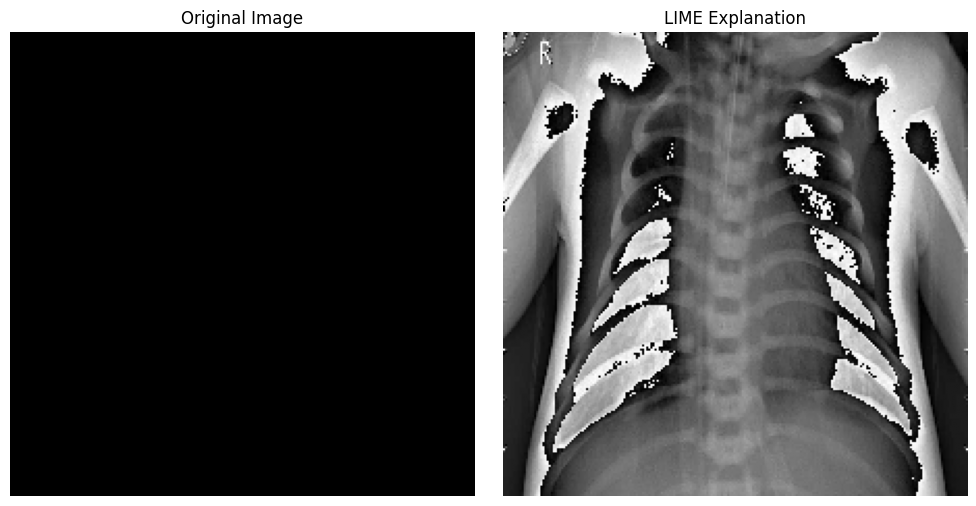

In [77]:
# --- IMPORTS ---
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# --- LOAD & PREPROCESS IMAGE ---
img_path = r"E:\desktop\kansal sir\chest_xray\test\PNEUMONIA\BACTERIA-227418-0001.jpeg"  # <-- change this path

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # For ResNetV2 preprocessing

# --- DEFINE LIME FUNCTION ---
def explain_with_lime(model, img_array, class_names=None):
    explainer = lime_image.LimeImageExplainer()
    
    explanation = explainer.explain_instance(
        np.uint8(img_array[0] * 255),             # single image
        classifier_fn=lambda x: model.predict(x), # model prediction
        top_labels=3,
        hide_color=0,
        num_samples=1000
    )

    # Get the explanation mask
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # --- SIDE-BY-SIDE DISPLAY ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    ax[0].imshow(img_array[0] / 255.0)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # LIME Explanation
    ax[1].imshow(mark_boundaries(temp / 255.0, mask))
    ax[1].set_title("LIME Explanation")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# --- RUN LIME ---
explain_with_lime(model_pretrained, img_array)



# SHAP (SHapley Additive exPlanations)

**SHAP** values explain the contribution of each feature (e.g., pixel, superpixel, etc.) to the model’s output.

Install SHAP if needed:
```bash
!pip install shap
```


In [79]:

import shap
import numpy as np
import matplotlib.pyplot as plt

# Example usage for deep learning models (Keras or PyTorch):
# Ensure you have a trained model and a sample input batch (e.g., first few test images).

def explain_with_shap(model, background_data, test_data, max_display=5):
    # background_data: representative background samples, shape (N, H, W, C)
    # test_data: samples you want to explain, shape (M, H, W, C)
    explainer = shap.Explainer(model, background_data)
    shap_values = explainer(test_data)
    shap.image_plot(shap_values, test_data, show=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


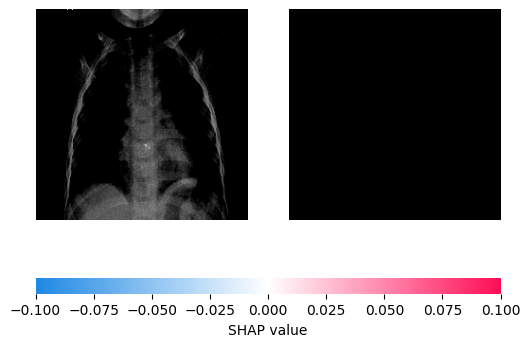

In [82]:
# --- IMPORTS ---
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# --- LOAD SAMPLE IMAGE ---
img_path = r"E:\desktop\kansal sir\chest_xray\test\PNEUMONIA\BACTERIA-821920-0002.jpeg"  # change path

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# --- BACKGROUND SAMPLE ---
# You can use a few samples from your training/test set as background (simplified here)
background = img_array.copy()

explainer = shap.GradientExplainer(model_pretrained, background)

# Get SHAP values
shap_vals = explainer.shap_values(img_array)

# Convert to list if needed
if not isinstance(shap_vals, list):
    shap_vals = [shap_vals]

# Plot the SHAP heatmap
shap.image_plot(shap_vals, img_array)



In [81]:
res = explainer.shap_values(img_array)
print(type(res))
try:
    print("len:", len(res))
except:
    pass
print("shapes:", [np.shape(x) for x in (res if isinstance(res, list) else [res])])


<class 'numpy.ndarray'>
len: 1
shapes: [(1, 224, 224, 3, 1)]
